In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from regression_ViT import regression_ViT as ViT 

import torch 
import torch.nn as nn

## Data

In [47]:
df = pd.read_csv('EjemploDatos.csv')
df.head()

,prediction date,"10u_(44.0, -9.5)","10u_(44.0, -9.375)","10u_(44.0, -9.25)","10u_(44.0, -9.125)","10u_(44.0, -9.0)","10u_(44.0, -8.875)","10u_(44.0, -8.75)","10u_(44.0, -8.625)","10u_(44.0, -8.5)",...,"vel100_(42.875, -6.0)","vel100_(43.0, -6.0)","vel100_(43.125, -6.0)","vel100_(43.25, -6.0)","vel100_(43.375, -6.0)","vel100_(43.5, -6.0)","vel100_(43.625, -6.0)","vel100_(43.75, -6.0)","vel100_(43.875, -6.0)","vel100_(44.0, -6.0)"
0,2016-01-01 00:00:00,1.577097,1.675974,1.836863,1.821115,1.681467,1.424021,1.190012,1.106394,1.108713,...,4.542353,5.321404,5.971150,5.862873,5.164530,5.391425,6.107658,6.398007,6.472929,6.793221
1,2016-01-01 01:00:00,1.320722,1.059857,1.200238,1.276654,1.713910,1.246137,0.725141,0.203412,0.215253,...,4.708214,5.435709,6.092992,5.361253,3.485183,3.988883,4.845162,5.260955,5.464975,5.908251
2,2016-01-01 02:00:00,1.562336,1.023518,0.415607,0.335896,0.563801,0.696369,0.487873,0.106770,-0.157024,...,4.553245,5.325067,6.018884,4.991258,2.281320,2.807106,3.654994,4.170403,4.632105,5.078648
3,2016-01-01 03:00:00,0.198002,0.025639,0.332890,-0.118526,-0.533199,-1.093990,-1.123653,-1.040646,-0.928341,...,4.668390,5.177444,5.716941,4.493564,1.185751,1.837592,3.329041,4.260316,4.934864,5.643699
4,2016-01-01 04:00:00,1.604583,1.043792,1.073821,0.065032,-0.961823,-1.394685,-1.394074,-1.230012,-1.500520,...,4.791137,5.317643,5.648662,4.902998,3.442938,3.724846,4.111763,4.328406,4.885375,5.730442


The EjemploDatos.csv contains 3481 columns that can be divided into: 
 - Prediction Date : day and hour 
 
 - 10u             : u component at height 10m
  
 - 10v             : v component at height 10m
 
 - 2t              : temperature at height 2m
 
 - sp              : pressure at surface
 
 - 100u            : u component at height 100m
 
 - 100v            : v component at height 100m
 
 - vel10           : module of the wind at height 10m
 
 - vel100          : module of the wind at height 100m
 

## Target

Observed production at Prediction Date (MWh)

Potencia máxima del parque: 17560Kwh (los datos, ya confirmado, están en Kwh

In [48]:
target_df = pd.read_csv('EjemploTarget.csv',
                        header=None)
target_df.head()

,0,1
0,2016-01-01 00:00:00,4126.70
1,2016-01-01 01:00:00,5688.51
2,2016-01-01 02:00:00,7742.01
3,2016-01-01 03:00:00,7660.50
4,2016-01-01 04:00:00,9730.48


In [49]:
target_df = pd.read_csv('EjemploTarget.csv', header=None)
target_df.head()

,0,1
0,2016-01-01 00:00:00,4126.70
1,2016-01-01 01:00:00,5688.51
2,2016-01-01 02:00:00,7742.01
3,2016-01-01 03:00:00,7660.50
4,2016-01-01 04:00:00,9730.48


In [50]:
target_df[1]

0     4126.70
1     5688.51
2     7742.01
3     7660.50
4     9730.48
5     9771.57
6     8619.96
7     9886.56
8    13056.48
Name: 1, dtype: float64

### Coordinates of interest

![Map](./figures/mapa.png)

In [51]:
# coordinates of interest
coordenates_of_interest = ['prediction date',

                            '(43.875, -8.375)', '(43.75, -8.375)', '(43.625, -8.375)', '(43.5, -8.375)', '(43.375, -8.375)', '(43.25, -8.375)', '(43.125, -8.375)', '(43.0, -8.375)', '(42.875, -8.375)',

                            '(43.875, -8.25)', '(43.75, -8.25)', '(43.625, -8.25)', '(43.5, -8.25)', '(43.375, -8.25)', '(43.25, -8.25)', '(43.125, -8.25)', '(43.0, -8.25)', '(42.875, -8.25)',
                            
                            '(43.875, -8.125)', '(43.75, -8.125)', '(43.625, -8.125)', '(43.5, -8.125)', '(43.375, -8.125)', '(43.25, -8.125)', '(43.125, -8.125)', '(43.0, -8.125)', '(42.875, -8.125)',

                           '(43.875, -8.0)', '(43.75, -8.0)', '(43.625, -8.0)', '(43.5, -8.0)', '(43.375, -8.0)', '(43.25, -8.0)', '(43.125, -8.0)', '(43.0, -8.0)', '(42.875, -8.0)',
                        
                           '(43.875, -7.875)','(43.75, -7.875)','(43.625, -7.875)','(43.5, -7.875)','(43.375, -7.875)','(43.25, -7.875)','(43.125, -7.875)','(43.0, -7.875)','(42.875, -7.875)',

                            '(43.875, -7.75)','(43.75, -7.75)','(43.625, -7.75)','(43.5, -7.75)','(43.375, -7.75)','(43.25, -7.75)','(43.125, -7.75)','(43.0, -7.75)','(42.875, -7.75)',

                            '(43.875, -7.625)','(43.75, -7.625)','(43.625, -7.625)','(43.5, -7.625)','(43.375, -7.625)','(43.25, -7.625)','(43.125, -7.625)','(43.0, -7.625)','(42.875, -7.625)',

                            '(43.875, -7.5)','(43.75, -7.5)','(43.625, -7.5)','(43.5, -7.5)','(43.375, -7.5)','(43.25, -7.5)','(43.125, -7.5)','(43.0, -7.5)','(42.875, -7.5)',

                            '(43.875, -7.375)','(43.75, -7.375)','(43.625, -7.375)','(43.5, -7.375)','(43.375, -7.375)','(43.25, -7.375)','(43.125, -7.375)','(43.0, -7.375)','(42.875, -7.375)',
                            
                           ]

In [16]:
# keep columns that contain any of the coordinates of interest
df = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]

/var/folders/_z/8tjgjv9d62qfwnfqwr1z6yl00000gq/T/ipykernel_2118/4242011990.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]


The resulting data has the same dimension as the data used in the paper "Deep Learning Applied to Wind Power Forecasting: a Spatio-Temporal Approach" fed to the Vision Transformer. 

In [17]:
df.head()

,prediction date,"10u_(43.875, -8.375)","10u_(43.875, -8.25)","10u_(43.875, -8.125)","10u_(43.875, -8.0)","10u_(43.875, -7.875)","10u_(43.875, -7.75)","10u_(43.875, -7.625)","10u_(43.875, -7.5)","10u_(43.875, -7.375)",...,"vel100_(43.875, -7.5)","vel100_(42.875, -7.375)","vel100_(43.0, -7.375)","vel100_(43.125, -7.375)","vel100_(43.25, -7.375)","vel100_(43.375, -7.375)","vel100_(43.5, -7.375)","vel100_(43.625, -7.375)","vel100_(43.75, -7.375)","vel100_(43.875, -7.375)"
0,2016-01-01 00:00:00,0.646799,0.940744,1.023264,0.863474,0.737864,0.503366,0.272409,0.131907,0.223703,...,7.685605,6.777981,7.208619,8.079643,8.283714,8.437874,8.417049,7.833382,7.427651,7.626461
1,2016-01-01 01:00:00,0.066449,0.209149,0.326459,0.294477,0.429730,0.099896,-0.319903,-0.740069,-0.581500,...,7.588559,6.671898,7.046983,8.140311,8.318516,8.475589,8.320119,7.561365,7.171789,7.649203
2,2016-01-01 02:00:00,-0.248577,-0.208050,-0.377850,-0.632000,-0.777508,-0.984661,-1.295086,-1.629803,-1.254192,...,8.390730,7.544478,7.833109,8.566935,8.423622,8.208681,7.951049,7.657357,7.868434,8.506869
3,2016-01-01 03:00:00,-0.939205,-0.826656,-1.048580,-1.244015,-1.253048,-1.262936,-1.560299,-2.039181,-2.125484,...,9.077174,8.745656,8.588821,8.887086,8.570982,8.070685,7.524815,7.277965,8.109472,9.125601
4,2016-01-01 04:00:00,-1.553864,-1.209870,-1.632600,-2.067414,-2.279450,-2.524446,-2.592317,-2.750764,-2.681672,...,8.777578,8.605917,8.417324,8.805204,8.697603,8.174285,7.259660,6.497139,7.239294,8.592414


In [18]:
# keep columns that contain 10u_(44.0,
df_10u = df.loc[:, df.columns.str.contains('10u')]

In [19]:
df_10u.head()

,"10u_(43.875, -8.375)","10u_(43.875, -8.25)","10u_(43.875, -8.125)","10u_(43.875, -8.0)","10u_(43.875, -7.875)","10u_(43.875, -7.75)","10u_(43.875, -7.625)","10u_(43.875, -7.5)","10u_(43.875, -7.375)","10u_(43.75, -8.375)",...,"10u_(43.0, -7.375)","10u_(42.875, -8.375)","10u_(42.875, -8.25)","10u_(42.875, -8.125)","10u_(42.875, -8.0)","10u_(42.875, -7.875)","10u_(42.875, -7.75)","10u_(42.875, -7.625)","10u_(42.875, -7.5)","10u_(42.875, -7.375)"
0,0.646799,0.940744,1.023264,0.863474,0.737864,0.503366,0.272409,0.131907,0.223703,-0.153250,...,-1.010427,-1.351492,-1.606131,-1.610159,-1.487844,-1.107473,-0.602835,-0.348196,-0.584890,-0.900564
1,0.066449,0.209149,0.326459,0.294477,0.429730,0.099896,-0.319903,-0.740069,-0.581500,-0.530108,...,-0.976764,-1.773761,-1.910846,-1.749713,-1.494586,-1.053912,-0.481647,-0.100299,-0.249713,-0.777545
2,-0.248577,-0.208050,-0.377850,-0.632000,-0.777508,-0.984661,-1.295086,-1.629803,-1.254192,-0.681927,...,-1.367107,-1.672649,-2.050579,-1.928631,-1.838665,-1.518597,-0.921062,-0.550701,-0.878582,-1.261517
3,-0.939205,-0.826656,-1.048580,-1.244015,-1.253048,-1.262936,-1.560299,-2.039181,-2.125484,-1.363033,...,-2.035763,-1.470943,-1.796139,-1.713131,-1.775265,-1.681515,-1.078365,-0.714230,-0.982174,-1.962154
4,-1.553864,-1.209870,-1.632600,-2.067414,-2.279450,-2.524446,-2.592317,-2.750764,-2.681672,-1.709870,...,-1.569123,-1.340241,-1.636384,-1.519685,-1.572297,-1.381745,-0.794953,-0.336213,-0.347688,-1.473054


### Creating multi-channel images (8 channels x9x9) as tensors

In [20]:
channels = ['10u', '10v', '2t', 'sp', '100u', '100v', 'vel10_', 'vel100']

image = []

for channel in channels: 
    image.append(df.loc[0, df.columns.str.contains(channel)].values.reshape(9,9))

# transform image to tensor
image = torch.tensor(np.array(image, dtype=np.float32)).permute(1,2,0)
image.shape

torch.Size([9, 9, 8])

Prediction date 2016-01-01 00:00:00


Text(0.5, 1.0, '2t')

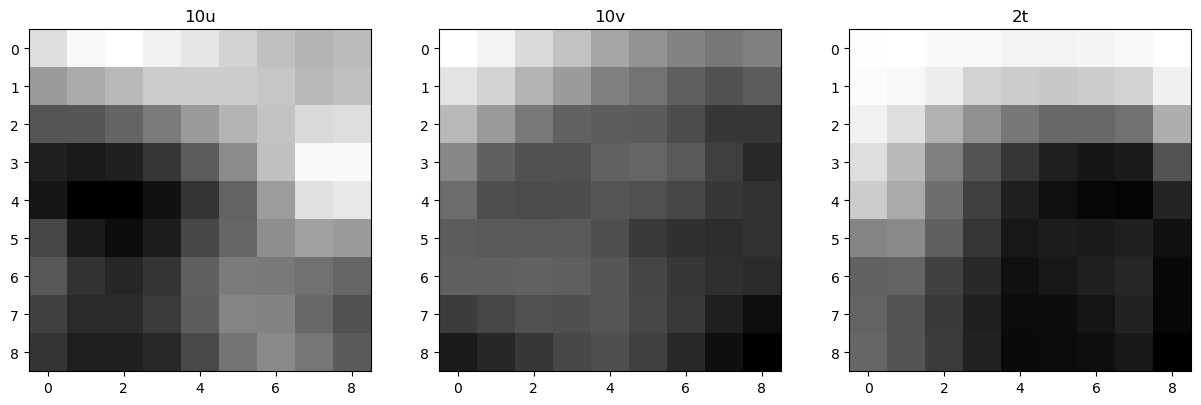

In [22]:
print('Prediction date 2016-01-01 00:00:00')

# subplot with 1x3 grid
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# plot images
ax[0].imshow(image[:,:,0],cmap='gray')
ax[1].imshow(image[:,:,1],cmap='gray')
ax[2].imshow(image[:,:,2],cmap='gray')

# set titles
ax[0].set_title('10u')
ax[1].set_title('10v')
ax[2].set_title('2t')

### Pytorch dataset 

In [67]:
def get_data_and_target_of_interest(df, target_df, coordenates_of_interest, channels):
    """
    Returns data of interest from df and target_df

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with all the data.
    target_df : pandas dataframe
        Dataframe with all the targets.
    coordenates_of_interest : list
        List with the coordinates of interest.
    channels : list
        List with the channel names to build the image.
    
    Returns
    -------
    data_of_interest : torch tensor
        Tensor with all the images of the coordinates of interest.
    target_of_interest : torch tensor
        Tensor with the target of interest.

    """
    # keep columns that contain any of the coordinates of interest
    df = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]
    print(df.shape)

    # get data of interest
    data_of_interest = []
    for i in range(df.shape[0]):
        image = []
        for channel in channels: 
            image.append(df.loc[i, df.columns.str.contains(channel)].values.reshape(9,9))
        data_of_interest.append(image)
    
    # transform data to tensor
    data_of_interest = torch.tensor(np.array(data_of_interest, dtype=np.float32))
    
    # get target of interest
    target_of_interest = torch.tensor(np.array(target_df[1].values, dtype=np.float32))
        
    return target_of_interest, data_of_interest

In [41]:
df1 = df.filter(regex='|'.join(coordenates_of_interest))
df2 = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]

/var/folders/_z/8tjgjv9d62qfwnfqwr1z6yl00000gq/T/ipykernel_2118/1517760462.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df2 = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]


In [68]:
def create_images(df, channels, image_size):
    """
    Creates images from the data in df.

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with all the data.
    channels : list
        List with the channel names to build the image.
    image_size : int
        Size of the image.

    Returns
    -------
    images : torch tensor
        Shape: (n_samples, n_channels, image_size, image_size)
        Tensor with all the images of the coordinates of interest.

    """
    images = np.zeros((df.shape[0], len(channels), image_size, image_size), dtype=np.float32)

    for i, channel in enumerate(channels):
        channel_data = df.filter(regex=channel).values.reshape(df.shape[0], image_size, image_size)
        images[:, i, :, :] = channel_data

    return torch.from_numpy(images)

In [72]:
def chat(df, target_df, coordenates_of_interest, channels, normalize_target=False, INSTALLED_POWER=17500):
    """
    Returns data of interest from df and target_df

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with all the data.
    target_df : pandas dataframe
        Dataframe with all the targets.
    coordenates_of_interest : list
        List with the coordinates of interest.
    channels : list
        List with the channel names to build the image.
    normalize_target : bool, optional
        If True, the target is normalized dividing by the maximum power. The default is False.
    
    Returns
    -------
    data_of_interest : torch tensor
        Shape: (n_samples, n_channels, 9, 9)
        Tensor with all the images of the coordinates of interest.
    target_of_interest : torch tensor
        Shape: (n_samples)
        Tensor with the target of interest.

    """
    # filter out unwanted columns from the data
    df = df.filter(regex='|'.join(coordenates_of_interest))
    print(df.shape)

    # create images
    data_of_interest = create_images(df, channels, image_size=9)
    
    # normalize target if needed
    target = target_df[1].values.astype(np.float32)
    if normalize_target:
        target /= INSTALLED_POWER

    return data_of_interest, torch.from_numpy(target)

In [73]:
df = pd.read_csv('EjemploDatos.csv')
target_df = pd.read_csv('EjemploTarget.csv', header=None)

target_of_interest, data_of_interest = get_data_and_target_of_interest(df, target_df, coordenates_of_interest, channels)
new_data_of_interest, new_target_of_interest = chat(df, target_df, coordenates_of_interest, channels)

#checl if the results are the same
print(torch.all(torch.eq(data_of_interest, new_data_of_interest)))
print(torch.all(torch.eq(target_of_interest, new_target_of_interest)))

/var/folders/_z/8tjgjv9d62qfwnfqwr1z6yl00000gq/T/ipykernel_2118/1419458357.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]


(9, 649)
(9, 649)
tensor(True)
tensor(True)


In [18]:
from torch.utils.data import Dataset, DataLoader

In [19]:
labels, data = get_data_and_target_of_interest(df, target_df, coordenates_of_interest, channels)

trainset = torch.utils.data.TensorDataset(data, labels)

/var/folders/_z/8tjgjv9d62qfwnfqwr1z6yl00000gq/T/ipykernel_10892/1689104833.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, df.columns.str.contains('|'.join(coordenates_of_interest))]


In [20]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True)

In [21]:
model = ViT(image_size=9, 
        patch_size=3, 
        channels=8,
        dim=64, 
        depth=6, 
        heads=8, 
        mlp_dim=128)

In [22]:
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 2
n_total_steps = len(trainloader)

# train the network
for epoch in range(num_epochs):  # loop over the dataset multiple times

    print(f"Epoch {epoch+1} of {2}")

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        labels = labels.unsqueeze(1).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
     
        # verbosity 
        print(f'epoch {epoch+1}/{num_epochs}; step {i+1}/{n_total_steps}, loss={loss.item():.4f}') 
    
     
print('Finished Training')

Epoch 1 of 2
epoch 1/2; step 1/5, loss=0.0554
epoch 1/2; step 2/5, loss=0.1781
epoch 1/2; step 3/5, loss=0.2475
epoch 1/2; step 4/5, loss=0.0278
epoch 1/2; step 5/5, loss=0.1307
Epoch 2 of 2
epoch 2/2; step 1/5, loss=0.1815
epoch 2/2; step 2/5, loss=0.0133
epoch 2/2; step 3/5, loss=0.0729
epoch 2/2; step 4/5, loss=0.0485
epoch 2/2; step 5/5, loss=0.0665
Finished Training


: 